# intro

## Autores

Juan Pablo Jaramillo Tobon CC 1216727112

Daniel Alejandro Higuita Usuga CC 1152706601

## Dataset

El conjunto de datos de polaridad de reseñas de Amazon se construye tomando las puntuaciones de reseñas 1 y 2 como negativas, y 4 y 5 como positivas. Se ignoran las muestras de puntuación 3. En el conjunto de datos, la clase 1 es negativa y la clase 2 es positiva.

Los CSV contienen polaridad, título y texto. Estas 3 columnas en ellos corresponden al índice de clase (1 o 2), título de la reseña y texto de la reseña.

 * Polaridad: 1 para negativo y 2 para positivo.
 * título - título de reseña
 * texto - cuerpo de reseña

## Objetivo

El objetivo es la creacion de un modelo que permita la clasificacion de reseñas de productos en amazon

## Proceso

describamos el proceso.....

* Limpieza ....

# experimento



In [1]:
%pip install nltk   

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Librerias

In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import re
from pandas import DataFrame
import joblib
import string

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')


#import sklearn.externals

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/estudiantelis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/estudiantelis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
## Cargar datos con colab
## =============================================================================

# from google.colab import drive
# import os

# drive.mount('/gdrive')

## 1 Dataset

In [4]:
# os.chdir("/gdrive/MyDrive/especializacion/aprendisaje automatico/amazon")
# !ls

In [5]:
# df=pd.read_csv('test.csv',names = ["clasificacion","titulo","reseña"])
df=pd.read_csv('archive (2)/test.csv',names = ["clasificacion","titulo","reseña"])

## 2 preparacion de datos

In [6]:
#Borrando columnas innecesarias
df.drop(['titulo'], axis='columns', inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   clasificacion  400000 non-null  int64 
 1   reseña         400000 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.1+ MB


In [8]:
df.describe()

,clasificacion
count,400000.000000
mean,1.500000
std,0.500001
min,1.000000
25%,1.000000
50%,1.500000
75%,2.000000
max,2.000000


In [9]:
#revisamos si tenemos duplicados
df.loc[df.duplicated()]

,clasificacion,reseña
3105,1,Rather pretentious comedy featuring Mel Gibson...
3406,2,This review relates to the Heritage 1944 editi...
5998,1,"Radius Technology DVDs ID as ""OPTODISC"" brand ..."
20621,1,Buena Vista (the company that releases Disney ...
47558,1,"Maybe this show appeals to some people, but to..."
...,...,...
384101,2,A must for the lovers of Edgar Allan Poe! Some...
385709,2,Really enjoyed this classic FPS. Hardcore game...
391533,2,Received product in a timely manner. Quality o...
398547,1,"Please, I beg of you, do not get involved with..."


In [10]:
#quitamos los duplicados
df = df.drop_duplicates()

lo hacemos mas pequeño

In [11]:
particion = (100-10)/100
documents = int(400000*(1-particion)*(0.01))
X_train, X_test, y_train, y_test = train_test_split(df['reseña'],df['clasificacion'], test_size=particion, random_state=42)
df = pd.concat([y_train, X_train], axis=1)

In [12]:
df.shape

(39991, 2)

In [13]:
df.groupby('clasificacion').count()

,reseña
clasificacion,
1,19902
2,20089


## 3  Preprocesamiento de texto y creación de bolsa de palabras

In [14]:
def preprocess(text):
  text = str(text)
  text = text.lower()
  text = re.sub(r'\d+', '', text)
  text = re.sub('\[.*?\]', '', text) #removes HTML tags
  text = re.sub('https?://\S+|www\.\S+', '', text) #removes url
  text = re.sub('[%s]' % re.escape(string.punctuation),'',text) #removes punctuations
  text = re.sub(r'[^\w\s]\d+', '', text)
  return text

In [15]:
df['reseña'] = df['reseña'].apply(preprocess)
df

,clasificacion,reseña
329976,1,as it is typed blues saraceno vhs that means v...
69134,1,i really hated this cd i just bought and it su...
262686,1,i was highly disgusted with this product when ...
110297,2,granted this movie seems to center around a yo...
85445,2,i started watching this show as reruns in on ...
...,...,...
259223,2,this is a replacement for our old steamer that...
365913,1,when i read this book i expect tom clancy qual...
131948,2,this product performs as advertised and is rea...
146884,2,released under the dogs damour moniker when ba...


In [16]:
#Stopwords
stop_words = stopwords.words('english')

#stemming
stemmer = SnowballStemmer('english')

In [17]:
#Creacion de bolsa de palabras
#documents = 4000
vectorizer = TfidfVectorizer(sublinear_tf=True       #transformación logarítmica suavizada en frcuencia de término.
                                                     # ayuda a reducir el impacto de las frecuencias de término altas
                                                     # y mejora el rendiemiento.
                             , min_df=documents           #los terminos deben aparecer en almenos 5 documentos
                             , ngram_range=(1, 3)
                             , stop_words=stop_words
                       )
features = vectorizer.fit_transform(df["reseña"])
labels = df['clasificacion']
features.shape

(39991, 563)

In [18]:
# terms = vectorizer.get_feature_names_out()

# doc_names = ['{:d}'.format(idx) for idx, _ in enumerate(features)]
# dv = pd.DataFrame(data=features.toarray(), index=doc_names, columns=terms)
# dv.head()

In [19]:
# Dataset con bolsa de palabras
# result = pd.merge(df[['clasificacion']], dv, on=[df[['clasificacion']].index, dv.index],  how="inner")
# result.drop(['key_0', 'key_1'], axis='columns', inplace=True)

# result[1:40]

In [20]:
# # se selecciona un regitro: para este caso el de index=4 y lo convierte en un arreglo NumPy.
# sr = result[4:5].to_numpy()

# # Crea una Serie 'sr' a partir del primer elemento del arreglo 'sr'.
# sr = pd.Series(sr[[0][0]])

# # Elimina el primer elemento de la Serie 'sr' (y almacena el resultado en 'sr2'). Se elimina el título de las columnas
# sr2 = sr.drop(sr.index[0])

# # Obtiene una lista de nombres de columnas en 'result' que tienen el tipo de dato 'float64'.
# index_ = result.select_dtypes(include=["float64"]).columns.tolist()

# # Establece los nombres de las columnas de 'sr2' según la lista de nombres de columnas obtenida anteriormente.
# sr2.index = index_

# # Invierte el orden de clasificación de 'sr2', obtiene los índices que ordenarían la Serie.
# r = (-sr2).argsort()

# # Imprime las 20 primeras palabras (o columnas) en función del orden especificado por 'r'.
# print(sr2[r][:20])

In [21]:
# df.iloc[4]['reseña']

## 4 eleccion de modelo

In [30]:

models = [
    RandomForestClassifier(n_estimators=100, max_depth=30, random_state=0),
    RandomForestClassifier(n_estimators=30, max_depth=60, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=11),
    KNeighborsClassifier(n_neighbors=21),
    KNeighborsClassifier(n_neighbors=41),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=1),
    GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=1)
]

#Cross-validation: 10-folds
CV = 20

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
a = 0
for model in models:
    model_name = model.__class__.__name__+str(a)
    a += 1
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV,n_jobs = 5)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

KeyboardInterrupt: 

In [22]:
cv_df[:][0:60]

,model_name,fold_idx,accuracy
0,RandomForestClassifier0,0,0.779000
1,RandomForestClassifier0,1,0.764000
2,RandomForestClassifier0,2,0.764500
3,RandomForestClassifier0,3,0.766500
4,RandomForestClassifier0,4,0.777000
5,RandomForestClassifier0,5,0.780390
6,RandomForestClassifier0,6,0.779390
7,RandomForestClassifier0,7,0.773387
8,RandomForestClassifier0,8,0.780890
9,RandomForestClassifier0,9,0.754377


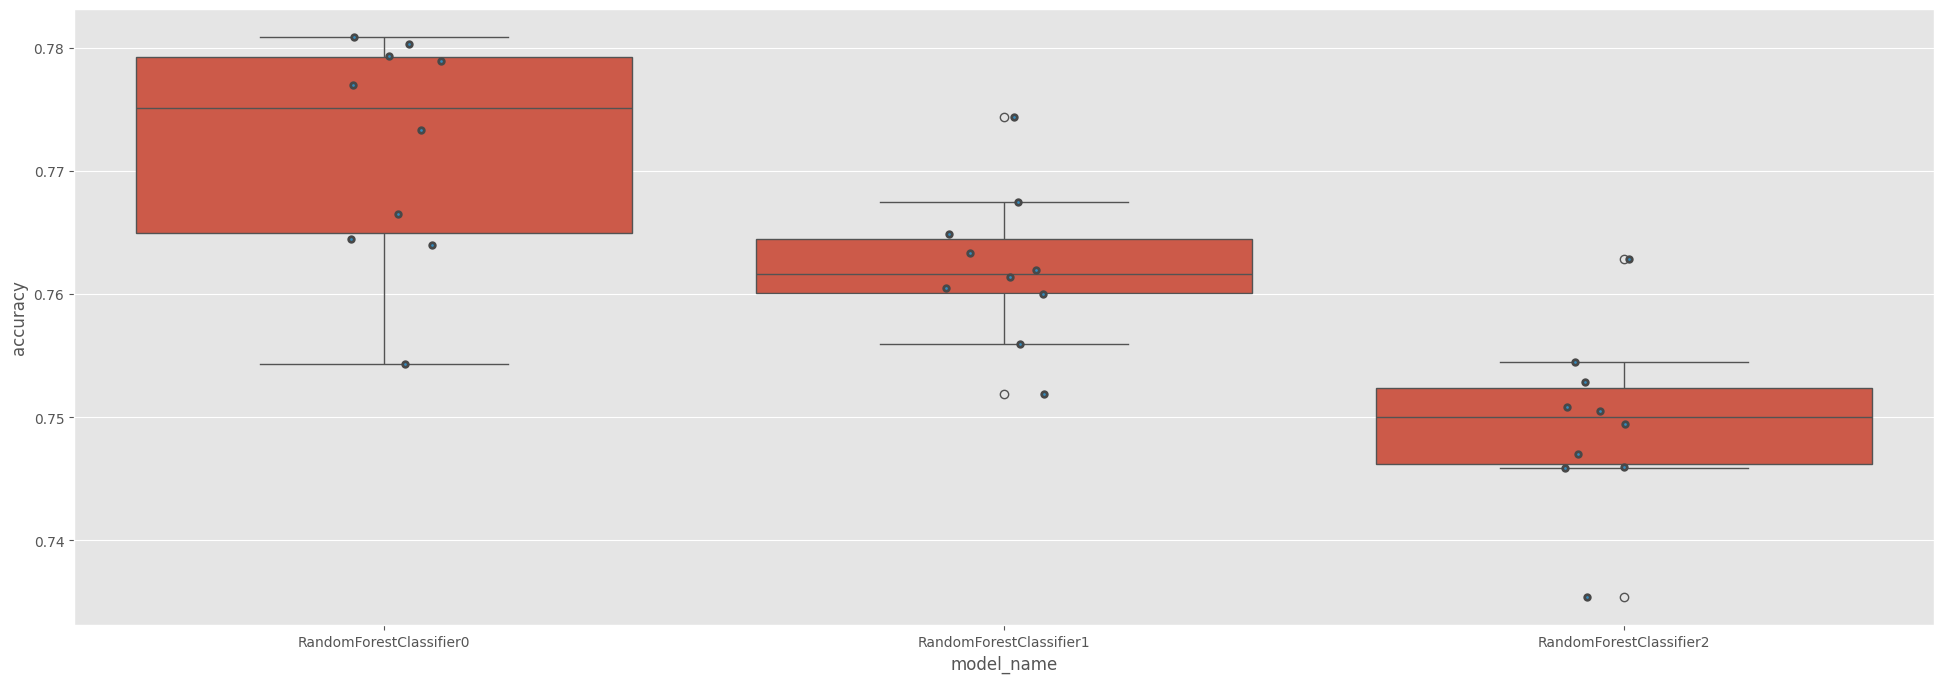

In [23]:
# Gráfica de accuracy de los modelos

figsize=(24,8)

plt.rcParams['figure.figsize'] = figsize

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=4, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [24]:
# Accuracy de los modelos

cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False)

model_name
LogisticRegression    0.802248
LinearSVC             0.800148
MultinomialNB         0.789447
Name: accuracy, dtype: float64

In [21]:

models = [
    RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0),
    RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0),
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
]

#Cross-validation: 10-folds
CV = 20

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
a = 0
for model in models:
    model_name = model.__class__.__name__+str(a)
    a+=1
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [49]:
"a"+"b"

'ab'